# ASTR Final Project - Aaron Kosoff

In this project I will map all the data

In [1]:
import numpy as np
import sep
import os

In [2]:
# additional setup for reading the test image and displaying plots
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [24]:
fits_directory = 'minimized_fits/'
hdu1 = 'min_jw02731-o001_t017_nircam_clear-f090w_i2d.fits'
hdu2 = 'min_jw02731-o001_t017_nircam_clear-f187n_i2d.fits'
hdu3 = 'min_jw02731-o001_t017_nircam_clear-f200w_i2d.fits'
hdu4 = 'min_jw02731-o001_t017_nircam_clear-f335m_i2d.fits'
hdu5 = 'min_jw02731-o001_t017_nircam_clear-f444w_i2d.fits'
hdu6 = 'min_jw02731-o001_t017_nircam_f444w-f470n_i2d.fits'

In [23]:
hdulist = fits.open(fits_directory+hdu1)
#fits_files = [os.path.join(fits_directory, f) for f in os.listdir(fits_directory) if f.endswith('.fits')]
#print(fits_files[0].data)
data = hdulist[0].data
#rdata = np.reshape(data,(,))

# Copies data to a new array, preserves the ordering of the original array
new_data = data.astype(data.dtype.newbyteorder("="))
# The same outcome as the previous operation
new_data = data.byteswap()
new_data = new_data.view(new_data.dtype.newbyteorder("="))
# Changes data in-place
data = data.byteswap()
data = data.view(data.dtype.newbyteorder("="))

In [5]:
print(np.shape(data))
print(data[0:5,0:5])

(8582, 14339)
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]


#### UH OH! We got NaNs! Time to scrap some code to deal with this from lecture 18!

In [6]:
def rescale_image(data,vmin=0.5,vmax=100):
    # copy the data to avoid accidentaly overwriting it
    data_tmp = data.copy()

    # compute the mean value over all data, excluding NaN (Not a Number)
    m = np.nanmean(data_tmp)

    # any data points below vpmin is assigned the value vpmin
    # any data points above vpmax is assigned the value vpmax
    vpmin = vmin * m
    vpmax = vmax * m
    data_tmp[data_tmp < vpmin] = vpmin
    data_tmp[data_tmp > vpmax] = vpmax
    
    # replace all NaN by vpmin
    data_tmp = np.nan_to_num(data_tmp,nan=vpmin)

    # apply log-scale
    data_tmp = np.log10(data_tmp)
    return data_tmp

In [7]:
rescaled_data = rescale_image(data,vmin=0.5,vmax=100)

0.18456519
0.117220744


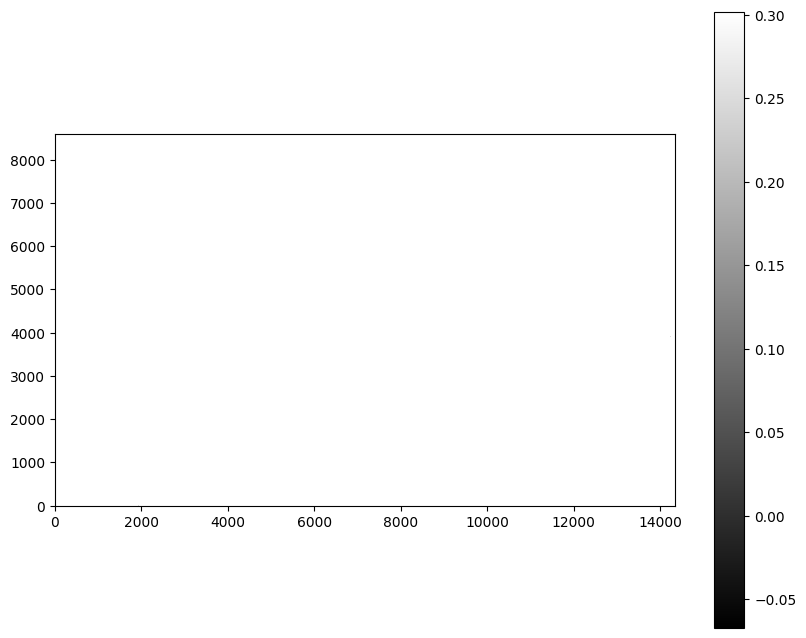

In [8]:
# show the image

m, s = np.mean(rescaled_data), np.std(rescaled_data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
print(s)
print(m)

In [9]:
mask = np.isnan(data)  # True where data is NaN

In [10]:
# measure a spatially varying background on the image
#bkg = sep.Background(data)
bkg = sep.Background(data, mask=mask)
#bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)

In [11]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

1.1997147798538208
0.06582547724246979


In [12]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

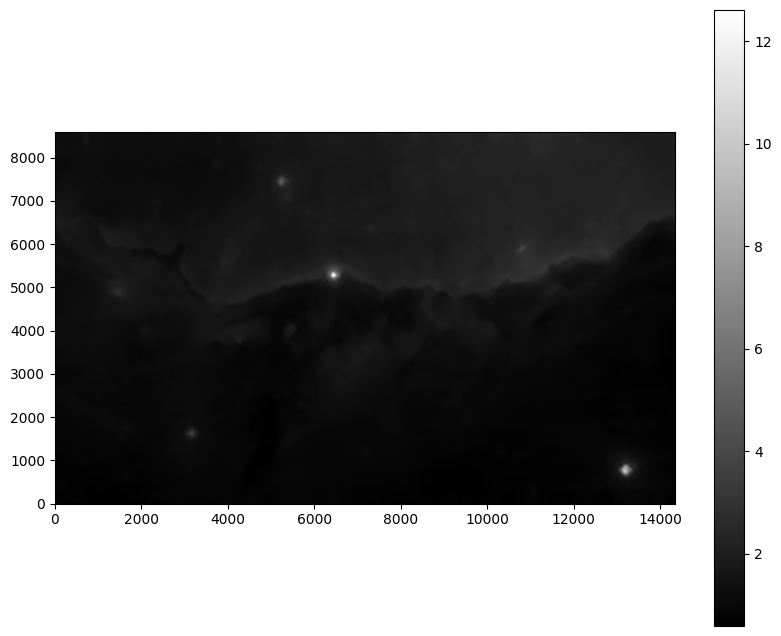

In [13]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

#save the figure
plt.savefig(hdu1+'bkg_image.png', bbox_inches = 'tight', facecolor = "white")

In [14]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()
bkg_rms = data - bkg.back()

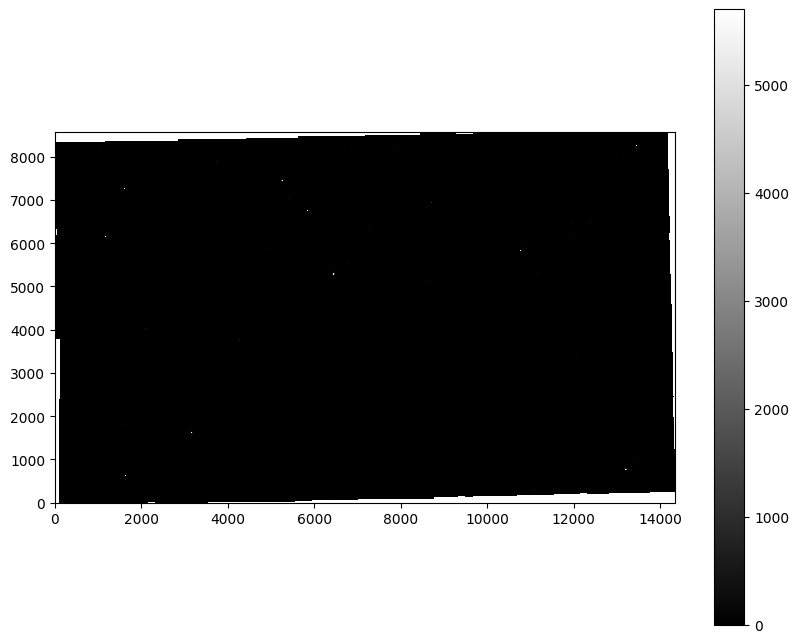

In [15]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

#save the figure
plt.savefig(hdu1+'bkg_rms.png', bbox_inches = 'tight', facecolor = "white")

In [16]:
# subtract the background
data_sub = data - bkg.back()

#### Here we define the detection threshold to be a constant value of 10$\sigma$ where $\sigma$ is the global background RMS

In [17]:
objects = sep.extract(data_sub, 10, err=bkg.globalrms, mask=mask)
print(len(objects))

11958


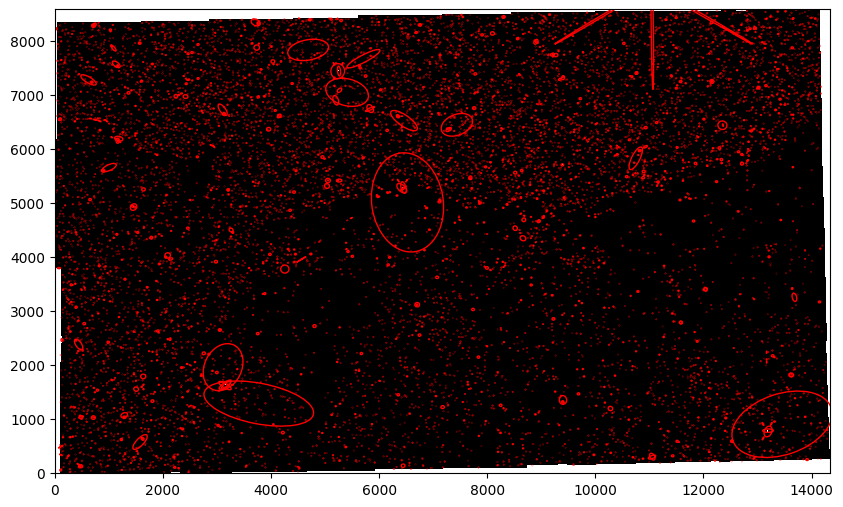

In [18]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

#save the figure
plt.savefig(hdu1+'objects.png', bbox_inches = 'tight', facecolor = "white")

In [19]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

#### Here, we calculate the flux of each of these objects to observe the given data

In [20]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0, mask=mask)

no_nan_flux = flux[np.isfinite(flux)] #We call this line so that we can properly map the fluxes onto a histogram

# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 36.589886 +/- 6.059121
object 1: flux = 11.585197 +/- 3.421581
object 2: flux = 249.575570 +/- 15.801828
object 3: flux = 36.325957 +/- 6.037201
object 4: flux = 474.404164 +/- 21.783642
object 5: flux = 15.155003 +/- 3.908605
object 6: flux = 56.966824 +/- 7.555762
object 7: flux = 19.046619 +/- 4.378220
object 8: flux = 80.441002 +/- 8.975719
object 9: flux = 21.400567 +/- 4.639337


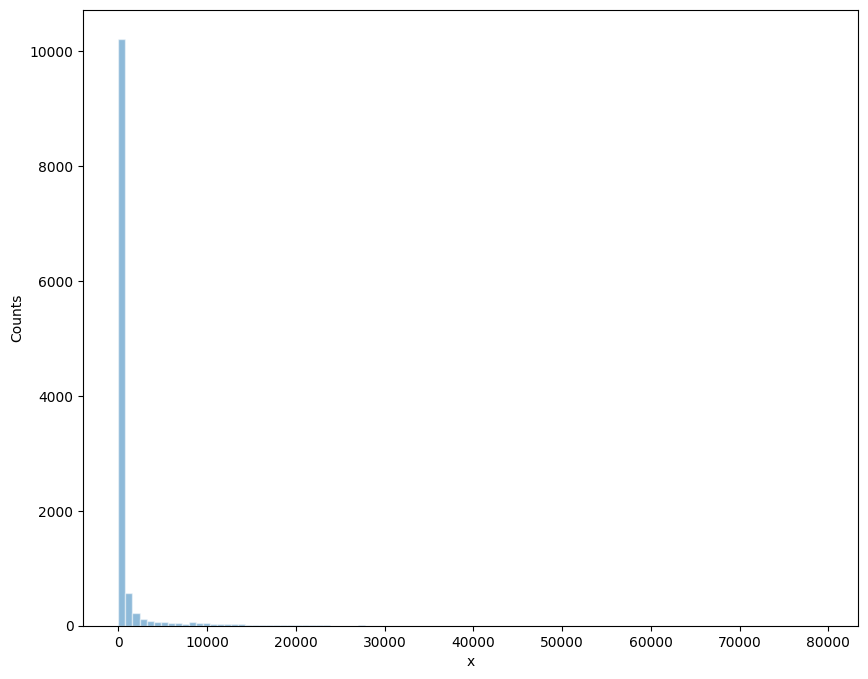

In [21]:
# create the histogram bins
width = 0.1
#hist_min = np.floor(min(x)) # take the lowest value of x, round it down
#hist_max = np.ceil(max(x)) + width #take the lowest value of x, round it up

#bins = np.arange(hist_min, hist_max, width) #this array contains the borders of the bins

# create the histogram
plt.hist(no_nan_flux, bins=100, alpha = 0.5, edgecolor='white')
#plt.hist(data, bins=10, alpha = 0.5, edgecolor='black')
plt.xlabel('x')
plt.ylabel('Counts')
plt.show()

#save the figure
plt.savefig(hdu1+'object_flux.png', bbox_inches = 'tight', facecolor = "white")